<div align="right">(11-May-2022)</div>
<h1>Illustrate Influence on Using Different Cluster Defining Compounds</h1>

Example Tubulin

### References:
1. Akbarzadeh, M.; Deipenwisch, I.; Schoelermann, B.; Pahl, A.; Sievers, S.; Ziegler, S.; Waldmann, H. Morphological Profiling by Means of the Cell Painting Assay Enables Identification of Tubulin-Targeting Compounds. Cell Chemical Biology 2021. https://doi.org/10.1016/j.chembiol.2021.12.009.

In [1]:
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to silence scikit-learn warnings

import warnings
warnings.filterwarnings('ignore')
warnings.warn = warn

# Type hints
from typing import Iterable, List, Set, Dict, Union, Optional


import pandas as pd

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem

import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Project-local Imports
from jupy_tools import plt_style
from jupy_tools import utils as u, mol_view as mv
from jupy_tools import cpa
from jupy_tools.utils import info
u.timestamp()

Timestamp: 03-Jun-2022 08:56:21


In [2]:
SIM_CUTOFF = 85.0

In [3]:
def heatmap(df_mp: pd.DataFrame, fn="heatmap", features=None):
    # cl_feat = sorted([x for x in df_mp.columns if x.startswith('Median_')])
    if features is None:
        features = cpa.ACT_PROF_FEATURES
    size = 2.77 + (17.0 * len(features) / 579)
    width = int(160.0 + (1020 * len(features) / 579))
    hm = cpa.heat_mpl(
        df_mp, id_prop="Well_Id", features=features, show=False, 
        img_size = size, img_tag_options=f'style="width: {width}px;"',
        # save_to_file=[f"plots/{fn}.png", f"plots/{fn}.svg"]
        save_to_file=f"plots/{fn}.svg"
    )

## Preparation

In [4]:
columns = ["Induction"]
ds = u.read_tsv("../input/ds_refs.tsv")
ds = u.replace_nans(ds, ["Known_Act", "Trivial_Name"], "")
info(set(ds["Compound_Id"]))
ds[columns].describe()

read_tsv                           : [    3547 / 589 ] 
replace_nans `Known_Act`           : [    3547 / 589 ]   12 values replaced. 
replace_nans `Trivial_Name`        : [    3547 / 589 ]  339 values replaced. 
Length Shape                       :      1883


,Induction
count,3547.000000
mean,32.550409
std,22.664884
min,5.000000
25%,12.300000
50%,27.500000
75%,48.900000
max,84.800000


## Generate Cluster Profiles
### Narrow Definition Only from Nocodazole, Vincristine, Vinblastine
(Compounds from fig. 1A of Lit. [1])

In [6]:
cluster = "tubulin_1"
cluster_cap = cluster.capitalize()
well_ids = ["245354:03:12_00.10", "281038:01:16_00.01", "281034:01:12_00.01"]
df = ds[ds["Well_Id"].isin(well_ids)].copy()
# Sort the filtered dataframe according to the Well_Id input list.
# StackOverflow: https://stackoverflow.com/a/58622999
# This is needed to have the correct order in the heatmap later on:
df = df.set_index('Well_Id').loc[well_ids].reset_index()

info(df)

Shape                              : [       3 / 589 ] 


Heatmap for the narrow definition:

In [ ]:
# cpa.heat_mpl(df, id_prop="Well_Id", show=False, save_to_file=f"plots/heatmap_{cluster}_narrow_full.svg")
heatmap(df, f"heatmap_{cluster}_narrow_full")

Calculate cluster features and median profile:

In [7]:
cl_feat = cpa.cluster_features(df, 0.85)
len(cl_feat)
df_mp = cpa.calc_median_profile(df, cl_feat, cluster_cap)
df_mp_tub_1 = df_mp.copy()
cl_feat_tub_1 = cl_feat.copy()
u.write_tsv(df_mp_tub_1, "data/df_mp_tub_1.tsv")
info(df_mp)

531

Shape                              : [       1 / 532 ] 


Find compounds similar to the median cluster profile:

In [10]:
act_prof = df_mp[cl_feat].values[0].astype("float64")
df_sim = cpa.find_similar(ds, act_prof, cutoff=SIM_CUTOFF, max_num=100, features=cl_feat)
info(df_sim, "Found similar")
info(df_sim["Compound_Id"].unique(), "Compounds")

Found similar                      : [      13 / 590 ] 
Length Compounds                   :         9


In [11]:
columns = ["Compound_Id", "Well_Id", "Induction", "Conc_uM", "Similarity", "Known_Act", "Trivial_Name", "Smiles"]
summary = f"""<h2>Measurements Similar to {cluster_cap}</h2>
Measurements that were found similar (&ge;{SIM_CUTOFF}%) to the Median Profile of {cluster_cap} generated from
Nocodazole, Vincristine, Vinblastine."""
tmp = df_sim[columns]
u.write_tsv(tmp, f"data/similar_to_{cluster}.tsv")
mv.write_mol_grid(tmp, fn=f"data/similar_to_{cluster}.html", title=cluster_cap, summary=summary, truncate=120)
df_sim_tub_1 = tmp.copy()

drop_cols                          : [      13 /   8 ]  1 columns removed. Compound_Id, Well_Id, Induction, Conc_uM, Similarity, Known_Act, Trivial_Name, Mol


Heatmap for the median profile of the narrow definition:

In [ ]:
heatmap(df_mp, f"heatmap_{cluster}_narrow_median_prof", features=cl_feat_tub_1)

### Broader Definition with Compounds from fig. 1B and 2 of Lit. [1] Plus Additional

The final definition list for the Tubulin cluster contains 18 compounds from fig. 1B and 2 of Lit. [1],  
plus some additional compounds that have been identified in the meantime (34 measurements in total).

In [5]:
cluster = "tubulin_2"
cluster_cap = cluster.capitalize()
cluster_cpds = u.read_tsv("../input/cluster_cpds.tsv")
well_ids = cluster_cpds.query('Cluster == "Tubulin"')["Well_Id"].values
len(well_ids)

df = ds[ds["Well_Id"].isin(well_ids)].copy()
df_tub_2 = df.copy()
columns = ["Well_Id", "Induction", "Conc_uM", "Known_Act", "Trivial_Name", "Smiles"]
summary = "Cluster-defining compounds for the Tubulin cluster."
mv.write_mol_grid(df_tub_2[columns], fn=f"data/cluster_cpds_tubulin_2.html", title="Tubulin_2", summary=summary, truncate=120)
print("Measurements:", len(well_ids))

info(df, "Measurements")
info(df.drop_duplicates(subset="Compound_Id"), "Compounds")


read_tsv                           : [     227 /   2 ] ( Well_Id, Cluster )


34

drop_cols                          : [      34 /   6 ]  1 columns removed. ( Well_Id, Induction, Conc_uM, Known_Act, Trivial_Name, Mol )


Measurements: 34
Measurements                       : [      34 / 589 ] 
Compounds                          : [      26 / 589 ] 


Full heatmap for the broader definition:

In [ ]:
heatmap(df, f"heatmap_{cluster}_broad_full")


Calculate cluster features and median profile:

In [6]:
cl_feat = cpa.cluster_features(df, 0.85)
len(cl_feat)
df_mp = cpa.calc_median_profile(df, cl_feat, cluster_cap)
df_mp_tub_2 = df_mp.copy()
cl_feat_tub_2 = cl_feat.copy()
info(df_mp)

424

Shape                              : [       1 / 425 ] 


Find compounds similar to the median cluster profile:

In [7]:
act_prof = df_mp[cl_feat].values[0].astype("float64")
df_sim = cpa.find_similar(ds, act_prof, cutoff=SIM_CUTOFF, max_num=300, features=cl_feat)
info(df_sim, "Found similar")
info(df_sim["Compound_Id"].unique(), "Compounds")

Found similar                      : [     128 / 590 ] 
Length Compounds                   :        88


In [8]:
cluster = "tubulin_2"

cluster_cap = cluster.capitalize()
columns = ["Compound_Id", "Well_Id", "Induction", "Conc_uM", "Similarity", "Known_Act", "Trivial_Name", "Smiles"]
summary = f"""<h2>Measurements Similar to {cluster_cap}</h2>
Measurements that were found similar (&ge;{SIM_CUTOFF}%) to the Median Profile of {cluster_cap} generated from
compounds from fig. 1B and 2 of <a href="https://doi.org/10.1016/j.chembiol.2021.12.009">Akbarzadeh et al., 2021</a>. plus additional compounds"""
tmp = df_sim[columns]
# u.write_tsv(tmp, f"data/similar_to_{cluster}.tsv")
mv.write_mol_grid(tmp, fn=f"data/similar_to_{cluster}.html", title=cluster_cap, summary=summary, truncate=120)
df_sim_tub_2 = tmp.copy()

drop_cols                          : [     128 /   8 ]  1 columns removed. Compound_Id, Well_Id, Induction, Conc_uM, Similarity, Known_Act, Trivial_Name, Mol


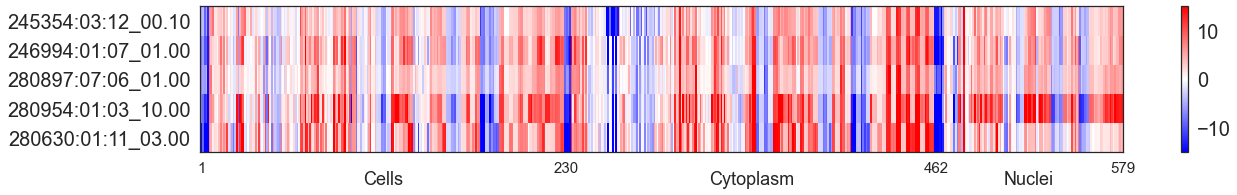

In [9]:
well_ids_sel = ["245354:03:12_00.10", "246994:01:07_01.00", "280897:07:06_01.00", "280954:01:03_10.00", "280630:01:11_03.00", ]
df_sel = df[df["Well_Id"].isin(well_ids_sel)].copy()
# Sort the filtered dataframe according to the Well_Id input list.
# StackOverflow: https://stackoverflow.com/a/58622999
# This is needed to have the correct order in the heatmap later on:
df_sel = df_sel.set_index('Well_Id').loc[well_ids_sel].reset_index()

cpa.heat_mpl(df_sel, id_prop="Well_Id", show=False, save_to_file=f"plots/heatmap_{cluster}_full.svg")

Generate a heatmap where the features that are not part of the Tubulin cluster are "whited out". In the final figure in the paper these areas are highlighted in black.  
Therefore, individual values that would also be displayed as white are changed to off-white. This is purely for illustration purposes in the paper and is not related to the actual algorithm used for creating and assigning the clusters:

155

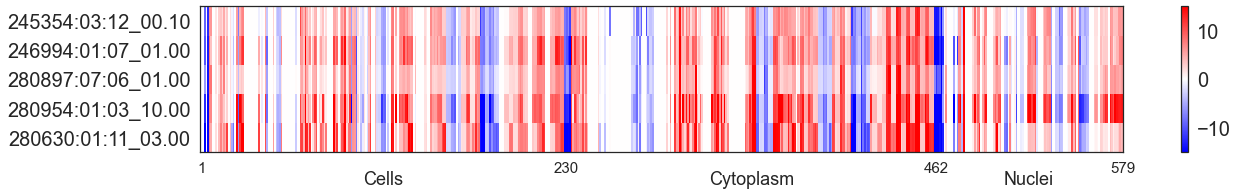

In [42]:
tmp = df_sel.copy()
cutoff = 0.25
# Did not find a way to do this vectorized (outside of a loop):
for feat in cpa.ACT_PROF_FEATURES:
    mask = (tmp[feat] < cutoff) & (tmp[feat] >=0.0)
    tmp[feat].mask(mask, cutoff, inplace=True)
    mask = (tmp[feat] >= -cutoff) & (tmp[feat] < 0.0)
    tmp[feat].mask(mask, -cutoff, inplace=True)
non_cl_feat = [f for f in cpa.ACT_PROF_FEATURES if f not in cl_feat]
len(non_cl_feat)
tmp[non_cl_feat] = 0.0
cpa.heat_mpl(tmp, id_prop="Well_Id", show=False, save_to_file=f"plots/heatmap_{cluster}_white_out.svg")


  - Re-calculating xticks...


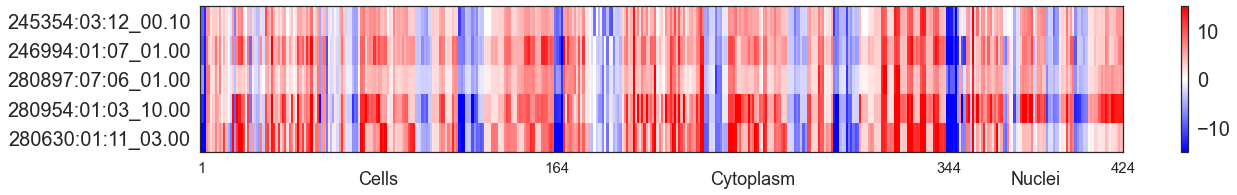

In [14]:
cpa.heat_mpl(df_sel, id_prop="Well_Id", features=cl_feat, show=False, save_to_file=f"plots/heatmap_{cluster}_cl_feat.svg")

  - Re-calculating xticks...


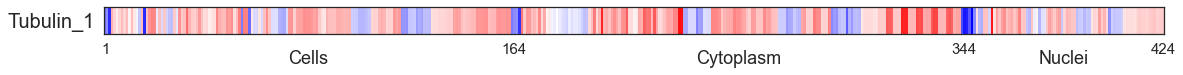

In [15]:
cpa.heat_mpl(df_mp, id_prop="Well_Id", features=cl_feat, show=False, save_to_file=f"plots/heatmap_{cluster}_median_prof.svg")

In [15]:
raise SystemExit(("Calculation done."))  # Used to stop the notebook from running the rest of the code.

SystemExit: Calculation done.

## Overlap Tubulin 1 & 2

In [16]:
df_overlap = pd.merge(df_sim_tub_1, df_sim_tub_2, on="Well_Id", how="inner")
info(df_overlap, "Overlap")

Overlap                            : [      12 /  15 ] 


In [17]:
df_sim_tub_1[~df_sim_tub_1["Well_Id"].isin(df_overlap["Well_Id"].values)]

,Compound_Id,Well_Id,Induction,Conc_uM,Similarity,Known_Act,Trivial_Name,Smiles
1627,413051,413051:01:04_01.00,68.2,1.0,90.2,"GSK-923295 (GSK923295) is a first-in-class, specific, allosteric inhibitor of CENP-E kinesin motor function. GSK923295 is uncompetitive with both ATP and MT, inhibiting CENP-E MT-stimulated ATPase activity with a Ki of 3.2±0.2 nM. GSK923295 inhibits release of inorganic phosphate and stabilized CENP-E motor domain interaction with microtubules.",GSK-923295,CC(C)Oc1ccc(C(=O)N[C@H](CNC(=O)CN(C)C)Cc2ccc(-c3cn4cccc([C@H](C)O)c4n3)cc2)cc1Cl


## Number of References with Tubulin Annotation

In [34]:
columns = ["Compound_Id", "Well_Id", "Induction", "Conc_uM", "Trivial_Name", "Known_Act", "Smiles"]
df_anno_tub = ds[ds["Known_Act"].str.contains("tubul", case=False)][columns]
df_anno_tub = df_anno_tub.sort_values(by="Well_Id")
u.write_tsv(df_anno_tub, "data/anno_tubulin.tsv")
info(df_anno_tub, "Annotated Tubulin")
len(df_anno_tub["Compound_Id"].unique())

Annotated Tubulin                  : [      21 /   7 ] ( Compound_Id, Well_Id, Induction, Conc_uM, Trivial_Name, Known_Act, Smiles )


11

## Similarities to Tubulin 1 & 2 Median Cluster Subprofiles
### Set A, Tubulin 1

              Well_Id  Similarity
0  280897:07:11_01.00        91.6
1  410973:01:03_02.00        85.9
2  280735:01:07_03.00        85.8
3  246994:01:07_01.00        85.6
  - Re-calculating xticks...


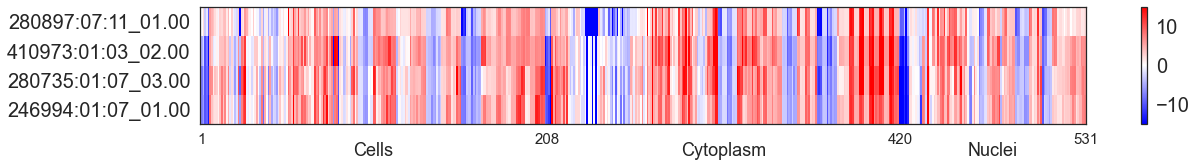

In [11]:
well_ids = [
    "280897:07:11_01.00",  # Rotenone
    "410973:01:03_02.00",  # TyK2-IN-2
    "280735:01:07_03.00",  # 2-Methoxyestradiol
    "246994:01:07_01.00",  # Albendazole
]
df_sel = ds[ds["Well_Id"].isin(well_ids)].copy()
# Sort the filtered dataframe according to the Well_Id input list.
# StackOverflow: https://stackoverflow.com/a/58622999
# This is needed to have the correct order in the heatmap later on:
df_sel = df_sel.set_index('Well_Id').loc[well_ids].reset_index()
# Add similarities to the median subprofile
act_prof = df_mp_tub_1[cl_feat_tub_1].values[0].astype("float64")
df_sim = cpa.find_similar(df_sel, act_prof, cutoff=0, max_num=300, features=cl_feat_tub_1, sort_by_similarity=False)
print(df_sim[["Well_Id", "Similarity"]])

heatmap(df_sel, "heatmap_set_a_tub_1", features=cl_feat_tub_1)


### Set A, Tubulin 2

              Well_Id  Similarity
0  280897:07:11_01.00        86.1
1  410973:01:03_02.00        94.7
2  280735:01:07_03.00        95.4
3  246994:01:07_01.00        95.1
  - Re-calculating xticks...


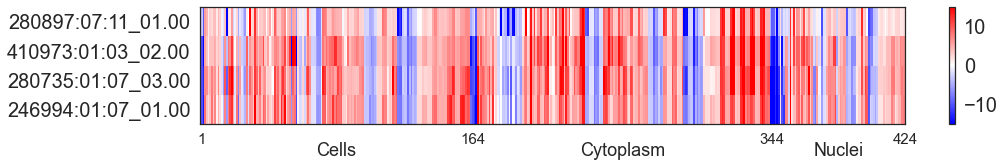

In [12]:
# Add similarities to the median subprofile
act_prof = df_mp_tub_2[cl_feat_tub_2].values[0].astype("float64")
df_sim = cpa.find_similar(df_sel, act_prof, cutoff=0, max_num=300, features=cl_feat_tub_2, sort_by_similarity=False)
print(df_sim[["Well_Id", "Similarity"]])

heatmap(df_sel, "heatmap_set_a_tub_2", features=cl_feat_tub_2)

### Set B, Tubulin 1

Other compounds that are also known for Tubulin activity, display a low similarity when the cluster is only defined from the narrow definition.

              Well_Id  Induction  Similarity
0  246514:02:04_06.00       65.5        71.6
1  410069:01:06_00.20       25.2        72.2
2  247195:02:03_30.00       38.0        67.4
  - Re-calculating xticks...


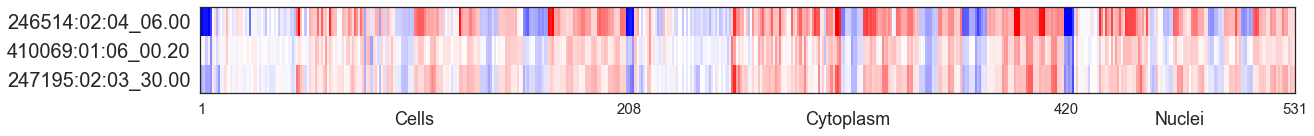

In [18]:
well_ids = [
    # TODO: Decide
    # "392625:01:09_00.20",  # KX2-391 ????  from 70% --> 81% biosimilarity (narrow to broad)
    "246514:02:04_06.00",  # HMG CoA reductase inhibitor Fluvastatin
    "410069:01:06_00.20",  # CAY10603, HDAC6 inhibitor
    "247195:02:03_30.00",  # Tetracaine HCl, local anaesthetic (30µM)
]
df_sel = ds[ds["Well_Id"].isin(well_ids)].copy()
# Sort the filtered dataframe according to the Well_Id input list.
# StackOverflow: https://stackoverflow.com/a/58622999
# This is needed to have the correct order in the heatmap later on:
df_sel = df_sel.set_index('Well_Id').loc[well_ids].reset_index()
# Add similarities to the median subprofile
act_prof = df_mp_tub_1[cl_feat_tub_1].values[0].astype("float64")
df_sim = cpa.find_similar(df_sel, act_prof, cutoff=0, max_num=300, features=cl_feat_tub_1, sort_by_similarity=False)
print(df_sim[["Well_Id", "Induction", "Similarity"]])

# cpa.heat_mpl(df_sel, id_prop="Well_Id", features=cl_feat_tub_1, show=False, save_to_file=f"plots/heatmap_set_b_tub_1.svg")
heatmap(df_sel, "heatmap_set_b_tub_1", features=cl_feat_tub_1)


### Set B, Tubulin 2

              Well_Id  Induction  Similarity
0  246514:02:04_06.00       65.5        85.7
1  410069:01:06_00.20       25.2        88.0
2  247195:02:03_30.00       38.0        85.9
  - Re-calculating xticks...


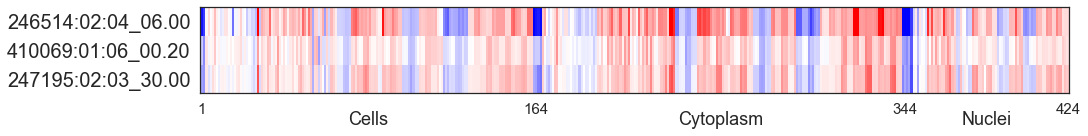

In [19]:
# Add similarities to the median subprofile
act_prof = df_mp_tub_2[cl_feat_tub_2].values[0].astype("float64")
df_sim = cpa.find_similar(df_sel, act_prof, cutoff=0, max_num=300, features=cl_feat_tub_2, sort_by_similarity=False)
print(df_sim[["Well_Id", "Induction", "Similarity"]])

heatmap(df_sel, "heatmap_set_b_tub_2", features=cl_feat_tub_2)